# R2X: Plexos & Sienna Comparison

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def add_missing_carriers(df1, df2):
    for carrier in df1.columns:
        if carrier not in df2.columns:
            df2[carrier] = 0
    for carrier in df2.columns:
        if carrier not in df1.columns:
            df1[carrier] = 0
    return df1, df2

In [3]:
colors_fuel = {
    "Natural gas": "#800080",
    "Hydropower": "#1f77b4",
    "Wind": "#87ceeb", 
    "Biopower": "#228b22",
    "Geothermal": "#8b4513",   
    "PV": "#ffd700",          
    "Storage": "#5dbb26",  
    "Storage_Charge": "#5dbb26",
    "Storage_Discharge": "#5dbb26",
    "Petroleum": "#333333", 
    "Other": "#bcbd22",     
    "Unserved Energy": "#ff0000", 
    "Curtailment": "#ff6347", 
    "Over Generation": "#00ff00",
}

fuel_name_mapper = { # Maps fuel names/ PM names to the fuel names used in Sienna data
    'OIL': 'Petroleum',
    'OTHER': 'Other',
    'HY': 'Hydropower',
    'WT': 'Wind',
    'WOOD_WASTE': 'Biopower',
    'WASTE_HEAT': 'Other',
    'GEOTHERMAL': 'Geothermal',
    'GAS': 'Natural gas',
    'PV': 'PV',
    'BA': 'Storage',
    'HYDROGEN': 'Other',
}

sienna_results_folder = Path('run_output/results')
plexos_results_path = Path('PLEXOS ST Results NVE 7_19_24.xlsx')

## Demand Comparison

In [4]:
# Read Sienna Demand
df_sienna_demand = (pd.read_csv(sienna_results_folder / 'load_active_power.csv') *-1)
df_sienna_demand

,DateTime,Nevada Power,Sierra
0,,2505.00,1832.89
1,,2379.29,1773.25
2,,2319.46,1734.14
3,,2288.37,1724.12
4,,2295.62,1731.20
...,...,...,...
163,,2701.45,2024.10
164,,2596.19,1966.78
165,,2477.42,1902.08
166,,2461.58,1895.96


In [5]:
# Read Plexos Results
df_plexos_load = pd.read_excel(plexos_results_path, sheet_name='Native Load')
df_plexos_load.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_load.rename(columns={"Datetime": "DateTime"}, inplace=True)
# Remove any zero load columns
df_plexos_load = df_plexos_load.iloc[:len(df_sienna_demand)]
df_plexos_load.set_index('DateTime', inplace=True)
df_plexos_load = df_plexos_load.loc[:, (df_plexos_load.sum(axis=0) != 0)]
df_plexos_load
df_plexos_load.head(5)


,Nevada Power,Sierra
DateTime,,
s,2505.00,1832.89
2030-01-01 01:00:00,2379.29,1773.25
2030-01-01 02:00:00,2319.46,1734.14
2030-01-01 03:00:00,2288.37,1724.12
2030-01-01 04:00:00,2295.62,1731.20


<Axes: >

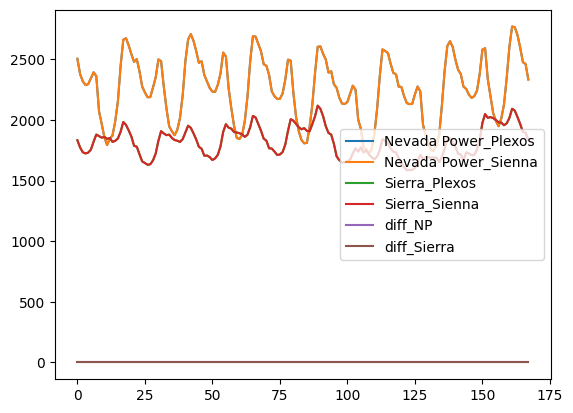

In [6]:
df_plexos_load = df_plexos_load[['Nevada Power', 'Sierra']].add_suffix('_Plexos')
df_sienna_demand = df_sienna_demand[['Nevada Power', 'Sierra']].add_suffix('_Sienna')

df = pd.DataFrame(
    [
        df_plexos_load['Nevada Power_Plexos'].reset_index(drop=True), 
        df_sienna_demand['Nevada Power_Sienna'].reset_index(drop=True),
        df_plexos_load['Sierra_Plexos'].reset_index(drop=True),
        df_sienna_demand['Sierra_Sienna'].reset_index(drop=True),
        ]
).T

df['diff_NP'] = df['Nevada Power_Plexos'] - df['Nevada Power_Sienna']
df['diff_Sierra'] = df['Sierra_Plexos'] - df['Sierra_Sienna']
df
df.plot()

## Generation Comparison

In [7]:
# Load Generator Fuel Mapping File
gen_properties = pd.read_csv(Path('../output/gen.csv'), index_col=0)
gen_properties['fuel_type'] = gen_properties.fuel.fillna(gen_properties.prime_mover_type)
gen_properties['fuel_name'] = gen_properties.fuel_type.map(fuel_name_mapper)
print(gen_properties.fuel_name.unique())
print(gen_properties.fuel_type.unique())

['Wind' 'PV' 'Storage' 'Hydropower' 'Other' 'Petroleum' 'Natural gas'
 'Biopower' 'Geothermal']
['WT' 'PV' 'BA' 'HY' 'OTHER' 'OIL' 'GAS' 'WOOD_WASTE' 'GEOTHERMAL']


In [8]:
# Read Plexos Results
df_plexos_generation = pd.read_excel(plexos_results_path, sheet_name='Generation')
df_plexos_generation.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_generation.rename(columns={"Datetime": "DateTime"}, inplace=True)
df_plexos_generation.set_index('DateTime', inplace=True)
# Add storage data
df_plexos_storage = pd.read_excel(plexos_results_path, sheet_name='Net_Gen (stor)')
df_plexos_storage.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_storage.rename(columns={"Datetime": "DateTime"}, inplace=True)
df_plexos_storage.set_index('DateTime', inplace=True)

df_plexos_generation = pd.concat([df_plexos_generation, df_plexos_storage], axis=1)
df_plexos_generation.head(5)

,Chuck Lenzi 1_A,Chuck Lenzi 1_B,Chuck Lenzi 2_A,Chuck Lenzi 2_B,"Clark 5, 6, 10_A","Clark 5, 6, 10_B","Clark 7, 8, 9_A","Clark 7, 8, 9_B",Harry Allen CC_A,Harry Allen CC_B,...,Battle Mountain Solar BESS,Boulder Solar III BESS,Dodge Flat Solar BESS,Dry Lake East Solar BESS,Dry Lake Solar BESS,Fish Springs Ranch Solar BESS,Gemini Solar BESS,Libra Solar BESS,Sierra Solar BESS,Sierra Solar II BESS
DateTime,,,,,,,,,,,,,,,,,,,,,
2030-01-01 00:00:00,0.0,263.0,248.636,263.000,0.0,0.0,0.0,0.0,250.875,290.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0
2030-01-01 01:00:00,0.0,263.0,214.500,263.000,0.0,0.0,0.0,0.0,250.875,250.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0
2030-01-01 02:00:00,0.0,263.0,214.500,263.000,0.0,0.0,0.0,0.0,250.875,250.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0
2030-01-01 03:00:00,0.0,263.0,214.500,242.977,0.0,0.0,0.0,0.0,250.875,250.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0
2030-01-01 04:00:00,0.0,263.0,263.000,263.000,0.0,0.0,0.0,0.0,290.000,290.000,...,0.0,0.0,0.0,0.0,0.0,0.0,122.033,0.0,307.035,0.0


/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_68202/3604882437.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_plexos_gen_by_fuel = df_plexos_generation.groupby(gen_properties.fuel_name, axis =1).sum()


<Axes: xlabel='DateTime'>

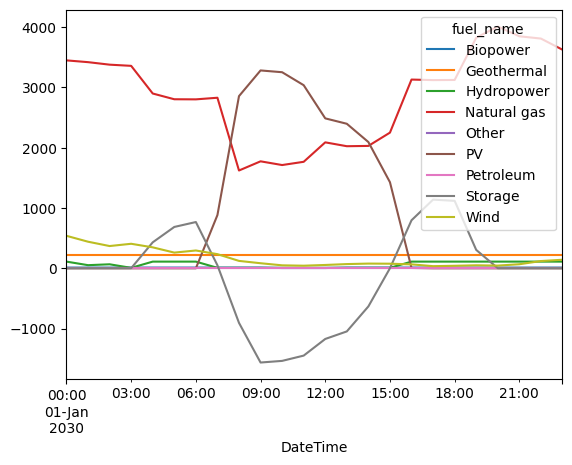

In [9]:
# Group plexos results by fuel type
df_plexos_gen_by_fuel = df_plexos_generation.groupby(gen_properties.fuel_name, axis =1).sum()
df_plexos_gen_by_fuel.head(24).plot()

In [10]:
# Read Sienna Resuts
df_gen_active_power = pd.read_csv(sienna_results_folder / 'generator_active_power.csv')
df_gen_by_fuel = pd.read_csv(sienna_results_folder / 'generation_by_fuel.csv')
df_storage_charge = pd.read_csv(sienna_results_folder / 'storage_charge.csv', index_col=0)
df_gen_active_power['DateTime'] = pd.to_datetime(df_gen_active_power['DateTime'])
df_gen_active_power.set_index('DateTime', inplace=True)
df_gen_by_fuel.index = df_gen_active_power.index
df_gen_by_fuel.head(5)

,Curtailment,Petroleum,Other,Wind,Biopower,Storage,Geothermal,PV,Natural gas,Hydropower
DateTime,,,,,,,,,,
2030-01-01 00:00:00,0.000000e+00,0.0,0.0,538.927074,0.0,0.0,282.25,0.0,3423.712926,93.0
2030-01-01 01:00:00,1.998401e-15,0.0,0.0,441.213188,0.0,0.0,282.25,0.0,3336.076812,93.0
2030-01-01 02:00:00,-5.684342e-14,0.0,0.0,369.354966,0.0,0.0,282.25,0.0,3308.995034,93.0
2030-01-01 03:00:00,0.000000e+00,0.0,0.0,406.914254,0.0,0.0,282.25,0.0,3236.184819,93.0
2030-01-01 04:00:00,5.329071e-15,0.0,0.0,347.742956,0.0,0.0,282.25,0.0,3303.827044,93.0


In [11]:
plexos = df_plexos_gen_by_fuel.loc[df_gen_by_fuel.index].copy()
sienna = df_gen_by_fuel.clip(lower=0) # clip small negative curtailment values
 
COLUMN_ORDER = ['Geothermal', 'Biopower', 'Hydropower', 'Petroleum', 'Other', 'Wind', 'PV', 'Natural gas','Unserved Energy', 'Curtailment', 'Over Generation', 'Storage']

plexos = plexos.reindex(columns=COLUMN_ORDER)
sienna = sienna.reindex(columns=COLUMN_ORDER)

plexos.head(5)

fuel_name,Geothermal,Biopower,Hydropower,Petroleum,Other,Wind,PV,Natural gas,Unserved Energy,Curtailment,Over Generation,Storage
DateTime,,,,,,,,,,,,
2030-01-01 00:00:00,219.086,12.0,111.000,0.0,6.0,538.927,0.0,3449.488,NaN,NaN,NaN,1.388
2030-01-01 01:00:00,219.086,12.0,52.053,0.0,6.0,441.213,0.0,3420.187,NaN,NaN,NaN,2.000
2030-01-01 02:00:00,219.086,12.0,66.581,0.0,6.0,369.355,0.0,3378.578,NaN,NaN,NaN,2.000
2030-01-01 03:00:00,219.086,12.0,7.634,0.0,6.0,406.914,0.0,3358.855,NaN,NaN,NaN,2.000
2030-01-01 04:00:00,219.086,12.0,111.000,0.0,6.0,347.743,0.0,2899.922,NaN,NaN,NaN,431.068


In [12]:
sienna.head(5)

,Geothermal,Biopower,Hydropower,Petroleum,Other,Wind,PV,Natural gas,Unserved Energy,Curtailment,Over Generation,Storage
DateTime,,,,,,,,,,,,
2030-01-01 00:00:00,282.25,0.0,93.0,0.0,0.0,538.927074,0.0,3423.712926,NaN,0.000000e+00,NaN,0.0
2030-01-01 01:00:00,282.25,0.0,93.0,0.0,0.0,441.213188,0.0,3336.076812,NaN,1.998401e-15,NaN,0.0
2030-01-01 02:00:00,282.25,0.0,93.0,0.0,0.0,369.354966,0.0,3308.995034,NaN,0.000000e+00,NaN,0.0
2030-01-01 03:00:00,282.25,0.0,93.0,0.0,0.0,406.914254,0.0,3236.184819,NaN,0.000000e+00,NaN,0.0
2030-01-01 04:00:00,282.25,0.0,93.0,0.0,0.0,347.742956,0.0,3303.827044,NaN,5.329071e-15,NaN,0.0


In [13]:
df_storage_charge.sum(axis=1) * -1

DateTime
2030-01-01T00:00:00.0   -0.000000
2030-01-01T01:00:00.0   -0.000000
2030-01-01T02:00:00.0   -0.000000
2030-01-01T03:00:00.0   -5.859073
2030-01-01T04:00:00.0   -0.000000
                           ...   
2030-01-07T19:00:00.0   -0.000000
2030-01-07T20:00:00.0   -0.000000
2030-01-07T21:00:00.0   -0.000000
2030-01-07T22:00:00.0   -0.000000
2030-01-07T23:00:00.0   -0.000000
Length: 168, dtype: float64

In [14]:
df_gen_by_fuel.Curtailment = df_gen_by_fuel.Curtailment.clip(lower=0) # clip small negative curtailment values
df_gen_by_fuel.loc[:,'Storage_Charge'] = df_storage_charge.sum(axis=1).values * -1
df_gen_by_fuel

,Curtailment,Petroleum,Other,Wind,Biopower,Storage,Geothermal,PV,Natural gas,Hydropower,Storage_Charge
DateTime,,,,,,,,,,,
2030-01-01 00:00:00,0.000000e+00,0.0,0.0,538.927074,0.0,0.000000,282.25,0.0,3423.712926,93.0,-0.000000
2030-01-01 01:00:00,1.998401e-15,0.0,0.0,441.213188,0.0,0.000000,282.25,0.0,3336.076812,93.0,-0.000000
2030-01-01 02:00:00,0.000000e+00,0.0,0.0,369.354966,0.0,0.000000,282.25,0.0,3308.995034,93.0,-0.000000
2030-01-01 03:00:00,0.000000e+00,0.0,0.0,406.914254,0.0,0.000000,282.25,0.0,3236.184819,93.0,-5.859073
2030-01-01 04:00:00,5.329071e-15,0.0,0.0,347.742956,0.0,0.000000,282.25,0.0,3303.827044,93.0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2030-01-07 19:00:00,0.000000e+00,0.0,0.0,113.649834,0.0,1153.072287,282.25,0.0,3083.577879,93.0,-0.000000
2030-01-07 20:00:00,0.000000e+00,0.0,0.0,75.679896,0.0,1028.462225,282.25,0.0,3083.577879,93.0,-0.000000
2030-01-07 21:00:00,0.000000e+00,0.0,0.0,57.762764,0.0,862.909357,282.25,0.0,3083.577879,93.0,-0.000000


In [15]:
sienna = df_gen_by_fuel
plexos = df_plexos_gen_by_fuel.loc[df_gen_by_fuel.index].copy()
 
COLUMN_ORDER = ['Geothermal', 'Biopower', 'Hydropower', 'Petroleum', 'Other', 'Wind', 'PV', 'Natural gas','Unserved Energy', 'Curtailment', 'Over Generation', 'Storage', 'Storage_Charge']

plexos = plexos.reindex(columns=COLUMN_ORDER)
sienna = sienna.reindex(columns=COLUMN_ORDER)
sienna.rename(columns={'Storage':'Storage_Discharge'}, inplace=True)


plexos['Storage_Charge'] = plexos['Storage'].clip(upper=0)
plexos['Storage_Discharge'] = plexos['Storage'].clip(lower=0)
plexos.drop(columns=['Storage'], inplace=True)

plexos, sienna = add_missing_carriers(plexos, sienna)

start_time = pd.Timestamp(2030, 1, 1)
end_time = pd.Timestamp(2030, 1, 7)

sienna = sienna.loc[start_time:end_time]
plexos = plexos.loc[start_time:end_time]

/Users/kamrantehranchi/miniforge3/envs/r2x/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


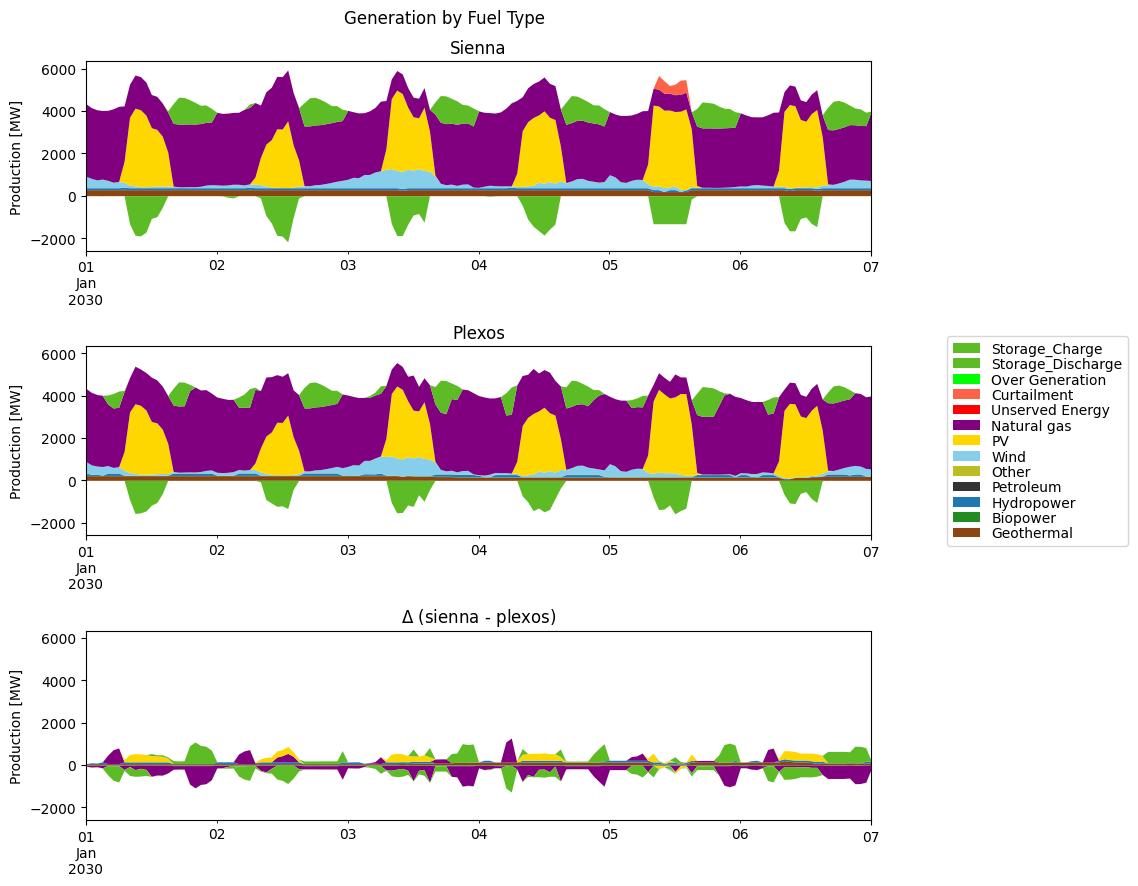

In [16]:
title='Generation by Fuel Type'; save_path='validation/generation_by_fuel.png'; colors=colors_fuel

kwargs = dict(color=colors, ylabel="Production [MW]", xlabel="", linewidth=0)

fig, axes = plt.subplots(3, 1, figsize=(9, 9))

# sienna_resampled = sienna.resample("1D").mean()
sienna.plot.area(
    ax=axes[0],
    **kwargs,
    legend=False,
    title="Sienna",
)
order = sienna.columns

# plexos_resampled = plexos.resample("1D").mean()[order]
plexos.plot.area(
    ax=axes[1],
    **kwargs,
    legend=False,
    title="Plexos",
)

diff = (sienna - plexos).fillna(0)#.resample("1D").mean()
diff.clip(lower=0).plot.area(
    ax=axes[2],
    title=r"$\Delta$ (sienna - plexos)",
    legend=False,
    **kwargs,
)
diff.clip(upper=0).plot.area(ax=axes[2], **kwargs, legend=False)

lower_lim = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0], axes[2].get_ylim()[0])
upper_lim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1], axes[2].get_ylim()[1])
axes[0].set_ylim(bottom=lower_lim, top=upper_lim)
axes[1].set_ylim(bottom=lower_lim, top=upper_lim)

# Set the limits for the difference subplot
diff_lim_upper = diff.clip(lower=0).sum(axis=1).max()
diff_lim_lower = diff.clip(upper=0).sum(axis=1).min()
axes[2].set_ylim(
    bottom=min(lower_lim, diff_lim_lower),
    top=max(upper_lim, diff_lim_upper),
)

h, l = axes[0].get_legend_handles_labels()
fig.legend(
    h[::-1],
    l[::-1],
    loc="center left",               # Aligns the legend to the left of the bounding box
    bbox_to_anchor=(1.05, 0.5),      # 1.05 moves it slightly outside the plot, 0.5 centers it vertically
    ncol=1,
    frameon=True,
    labelspacing=0.1,
)

plt.suptitle(title)
fig.tight_layout()
fig.savefig(save_path, dpi=300)

# Outstanding Issues

## R2X


## Sienna
- MarketBid Cost
- Max Energy Monthly for Market Purchases ThermalStandard Objects, and for The Hydro Resources

Max Energy Month:
- imports as transmission interface with a schedule. ... max energy month gets captured on the interfaces.

Services:
- turn off A/S for storage , and once completely

Plotting:
- LMP spread